#**Sentiment Analysis for any website**

###**Analysis for whole web page**

Replace the existing url with the actual url which needs to be tested.

In [8]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from ipywidgets import interact, widgets, Layout
from IPython.display import display, clear_output
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

def scrape_website(url):
    # Send a request to the website
    response = requests.get(url)
    # Parse the website content
    soup = BeautifulSoup(response.content, 'html.parser')
    # Extract text from paragraphs
    paragraphs = soup.find_all('p')
    text = [para.get_text() for para in paragraphs]
    return text

def analyze_sentiment_vader(text):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Analyze sentiment for each sentence
    sentiments = []
    for sentence in text:
        scores = sid.polarity_scores(sentence)
        sentiments.append(scores)

    return sentiments

def visualize_sentiments_vader(sentiments):
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(sentiments)

    # Count sentiment categories
    sentiment_counts = df['compound'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')).value_counts()

    # Create Plotly figure with subplots
    fig = make_subplots(rows=1, cols=3, specs=[[{'type':'bar'}, {'type':'pie'}, {'type':'violin'}]], subplot_titles=('Sentiment Analysis of Website Content (VADER)', 'Sentiment Distribution (VADER)', 'Horizontal Violin Plot of Sentiment Scores (VADER)'))

    # Bar chart
    fig.add_trace(
        go.Bar(x=sentiment_counts.index, y=sentiment_counts.values, marker_color=['#1f77b4', '#ff7f0e', '#2ca02c']),
        row=1, col=1
    )

    # Pie chart
    fig.add_trace(
        go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values, hole=0.3),
        row=1, col=2
    )

    # Horizontal violin plot (swap x and y for horizontal orientation)
    fig.add_trace(
        go.Violin(y=df['compound'], box_visible=True, line_color='black', meanline_visible=True, fillcolor='lightblue', opacity=0.6),
        row=1, col=3
    )

    # Update layout
    fig.update_layout(title_text='Sentiment Analysis and Visualization (VADER)', showlegend=False)

    # Show figure
    fig.show()

def generate_wordcloud(text, max_words=100, background_color='white', width=800, height=400):
    # Combine all text into a single string
    combined_text = " ".join(text)

    # Generate word cloud
    wordcloud = WordCloud(max_words=max_words, background_color=background_color, width=width, height=height).generate(combined_text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Website Content')
    plt.show()

def interactive_wordcloud(text):
    def update_wordcloud(max_words, background_color):
        clear_output(wait=True)
        generate_wordcloud(text, max_words=max_words, background_color=background_color)

    max_words_slider = widgets.IntSlider(value=100, min=50, max=200, step=10, description='Max Words:', style={'description_width': 'initial'}, layout=Layout(width='50%'))
    background_color_picker = widgets.ColorPicker(value='white', description='Background Color:', style={'description_width': 'initial'}, layout=Layout(width='50%'))

    interact(update_wordcloud, max_words=max_words_slider, background_color=background_color_picker)

if __name__ == "__main__":
    # URL of the website to scrape
    url = 'https://www.yelp.com/biz/re-yoga-therapy-wellness-los-angeles'  # Replace with the actual URL

    # Scrape the website
    website_text = scrape_website(url)

    # Perform sentiment analysis using VADER
    vader_sentiments = analyze_sentiment_vader(website_text)

    # Visualize sentiment analysis results using VADER (Plotly for interactivity)
    visualize_sentiments_vader(vader_sentiments)

    # Interactive word cloud generation
    interactive_wordcloud(website_text)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


interactive(children=(IntSlider(value=100, description='Max Words:', layout=Layout(width='50%'), max=200, min=…

###**Finding reasons for predictions**

In [9]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Download NLTK tokenizer models if not already downloaded
nltk.download('punkt')
# Download NLTK VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

def scrape_website(url):
    # Send a request to the website
    response = requests.get(url)
    # Parse the website content
    soup = BeautifulSoup(response.content, 'html.parser')
    # Extract text from paragraphs
    paragraphs = soup.find_all('p')
    text = [para.get_text() for para in paragraphs]
    return text

def analyze_sentiment_vader(text):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Analyze sentiment for each sentence
    sentiments = []
    for sentence in text:
        scores = sid.polarity_scores(sentence)
        scores['sentence'] = sentence  # Include the original sentence for analysis
        sentiments.append(scores)

    return sentiments, sid

def print_sentiment_reasons(sentences, sentiment_type, sid):
    print(f"\n{sentiment_type.capitalize()} Sentences and Their Reasons:")
    for idx, sentence in enumerate(sentences.head(5)):  # Print top 5 sentences
        print(f"\nReason {idx + 1}: {sentence}")
        # Tokenize the sentence into words
        words = nltk.word_tokenize(sentence)
        # Print the words contributing to the sentiment
        for word in words:
            sentiment_score = sid.polarity_scores(word)['compound']
            if sentiment_type == 'positive' and sentiment_score > 0:
                print(f"- Positive: {word}")
            elif sentiment_type == 'negative' and sentiment_score < 0:
                print(f"- Negative: {word}")
            elif sentiment_type == 'neutral' and sentiment_score == 0:
                print(f"- Neutral: {word}")

if __name__ == "__main__":
    # URL of the website to scrape
    url = 'https://www.yelp.com/biz/re-yoga-therapy-wellness-los-angeles'  # Replace with the actual URL

    # Scrape the website
    website_text = scrape_website(url)

    # Perform sentiment analysis using VADER
    vader_sentiments, sid = analyze_sentiment_vader(website_text)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(vader_sentiments)

    # Classify sentences into positive, negative, and neutral based on compound score
    positive_sentences = df[df['compound'] > 0]['sentence']
    negative_sentences = df[df['compound'] < 0]['sentence']
    neutral_sentences = df[df['compound'] == 0]['sentence']

    # Print reasons for each sentiment category
    print_sentiment_reasons(positive_sentences, 'positive', sid)
    print_sentiment_reasons(negative_sentences, 'negative', sid)
    print_sentiment_reasons(neutral_sentences, 'neutral', sid)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Positive Sentences and Their Reasons:

Reason 1: Group fitness
- Positive: fitness

Reason 2: Virtual fitness classes
- Positive: fitness

Reason 3: Creative Professionals Life Coach here to help you achieve your Next Level goals through Community, Discipline and Courage.read more
- Positive: Creative
- Positive: help

Reason 4: 5.6 miles away from re:YOGA Therapy + Wellness
- Positive: Wellness

Reason 5: 5.9 miles away from re:YOGA Therapy + Wellness
- Positive: Wellness

Negative Sentences and Their Reasons:

Reason 1: Jessica S. said"I am one of the pickiest people when it comes to getting massages or other services. I have never written a review on Yelp and am hesitant to write this (because I don't want Liz to be too busy for me), but feel inclined to share…"read more
- Negative: hesitant

Reason 2: 1 other review that is not currently recommended

Neutral Sentences and Their Reasons:

Reason 1: Write a Review
- Neutral: Write
- Neutral: a
- Neutral: Review

Reason 2: Start a Pr

### **Trend over time**

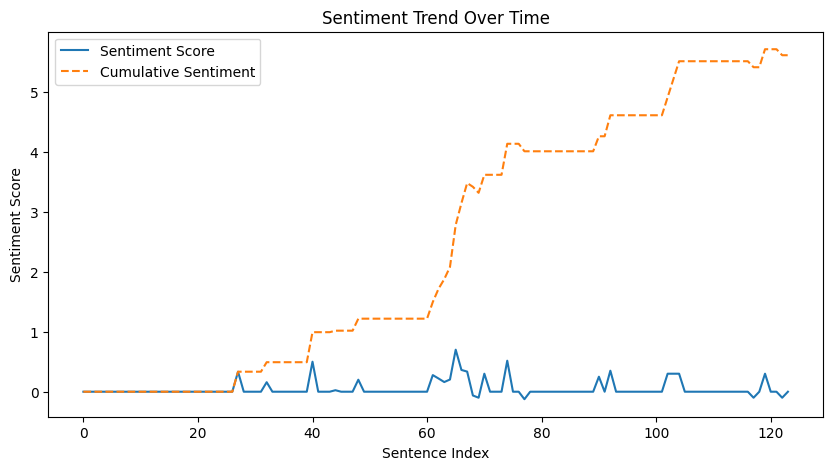

In [16]:
import matplotlib.pyplot as plt
from textblob import TextBlob

def analyze_sentiment_textblob(text):
    sentiments = []
    for sentence in text:
        analysis = TextBlob(sentence)
        sentiment = analysis.sentiment.polarity
        sentiments.append({'polarity': sentiment})
    return sentiments

# Compare VADER with TextBlob
textblob_sentiments = analyze_sentiment_textblob(website_text)
plot_sentiment_trend(textblob_sentiments)



###**Testing Model**

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Results:
                                                  Text Ground Truth Prediction
0        I love this place! The atmosphere is amazing.     Positive   Positive
1        The instructor seemed disinterested and rude.     Negative   Negative
2    It was an average class with nothing extraordi...      Neutral    Neutral
3    Fantastic experience with great attention to d...     Positive   Positive
4                    It was a waste of time and money.     Negative   Negative
..                                                 ...          ...        ...
119  The yoga class schedule is inconvenient, makin...     Negative   Negative
120  The instructor’s guidance during the yoga sess...     Positive   Positive
121  The yoga retreat was a life-changing experienc...     Positive   Positive
122  I found the yoga poses too challenging, which ...     Negative   Negative
123  Yoga has helped me improve my flexibility and ...     Positive   Positive

[124 rows x 3 columns]

Accuracy: 77.42%



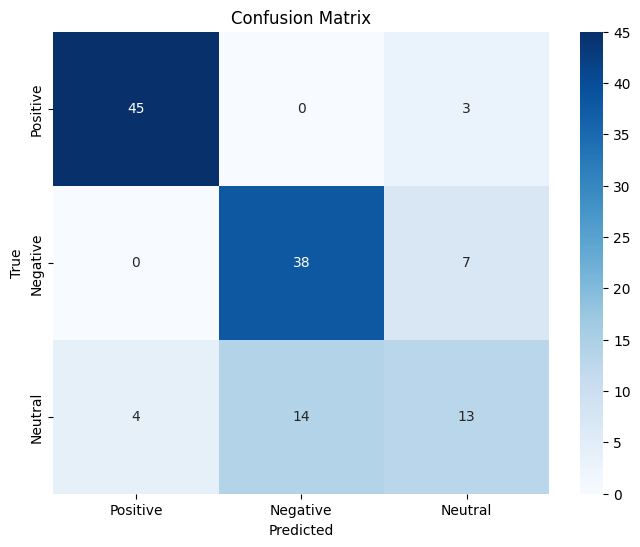

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure VADER lexicon is downloaded
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def scrape_website(url, max_sentences=100):
    # Send a request to the website
    response = requests.get(url)
    # Parse the website content
    soup = BeautifulSoup(response.content, 'html.parser')
    # Extract text from paragraphs
    paragraphs = soup.find_all('p')
    text = [para.get_text() for para in paragraphs]
    sentences = []
    for para in text:
        sentences.extend(para.split('. '))
    return sentences[:max_sentences]

def analyze_sentiment_vader(texts):
    sentiments = []
    for text in texts:
        scores = sid.polarity_scores(text)
        sentiments.append(scores)
    return sentiments

def get_predictions(sentiments):
    return [
        'Positive' if score['compound'] > 0 else
        ('Negative' if score['compound'] < 0 else 'Neutral')
        for score in sentiments
    ]

# URL of the website to scrape
url = 'https://www.yelp.com/biz/re-yoga-therapy-wellness-los-angeles'  # Replace with the actual URL

# Example ground truth labels for 100 sentences
# Replace these with actual labeled sentences from the website content
ground_truth = [
    {'text': 'I love this place! The atmosphere is amazing.', 'sentiment': 'Positive'},
    {'text': 'The instructor seemed disinterested and rude.', 'sentiment': 'Negative'},
    {'text': 'It was an average class with nothing extraordinary.', 'sentiment': 'Neutral'},
    {'text': 'Fantastic experience with great attention to detail.', 'sentiment': 'Positive'},
    {'text': 'It was a waste of time and money.', 'sentiment': 'Negative'},
    {'text': 'The yoga class was neither good nor bad.', 'sentiment': 'Neutral'},
    {'text': 'A serene environment that promotes relaxation.', 'sentiment': 'Positive'},
    {'text': 'The facilities were dirty and unkempt.', 'sentiment': 'Negative'},
    {'text': 'The class was standard and met my expectations.', 'sentiment': 'Neutral'},
    {'text': 'Excellent service and highly recommend it!', 'sentiment': 'Positive'},
    {'text': 'The instructor was late and unprepared.', 'sentiment': 'Negative'},
    {'text': 'It was neither exciting nor boring.', 'sentiment': 'Neutral'},
    {'text': 'The ambiance is very calming and pleasant.', 'sentiment': 'Positive'},
    {'text': 'I felt neglected and ignored.', 'sentiment': 'Negative'},
    {'text': 'The class was exactly what I expected.', 'sentiment': 'Neutral'},
    {'text': 'Highly skilled instructors and great atmosphere.', 'sentiment': 'Positive'},
    {'text': 'The yoga mats were old and worn out.', 'sentiment': 'Negative'},
    {'text': 'The session was average but acceptable.', 'sentiment': 'Neutral'},
    {'text': 'An exceptional place for yoga and mindfulness.', 'sentiment': 'Positive'},
    {'text': 'The staff was unfriendly and unhelpful.', 'sentiment': 'Negative'},
    {'text': 'The experience was as expected, nothing special.', 'sentiment': 'Neutral'},
    {'text': 'A wonderful retreat for relaxation and peace.', 'sentiment': 'Positive'},
    {'text': 'The instructor’s attitude was off-putting.', 'sentiment': 'Negative'},
    {'text': 'It was an ordinary session with no highlights.', 'sentiment': 'Neutral'},
    {'text': 'The atmosphere is soothing and perfect for yoga.', 'sentiment': 'Positive'},
    {'text': 'The class was poorly organized and chaotic.', 'sentiment': 'Negative'},
    {'text': 'The experience was mediocre at best.', 'sentiment': 'Neutral'},
    {'text': 'Fantastic yoga experience, would definitely return.', 'sentiment': 'Positive'},
    {'text': 'The equipment was subpar and uncomfortable.', 'sentiment': 'Negative'},
    {'text': 'The class did not stand out from others.', 'sentiment': 'Neutral'},
    {'text': 'A great place to unwind and practice yoga.', 'sentiment': 'Positive'},
    {'text': 'The instructor was disrespectful and dismissive.', 'sentiment': 'Negative'},
    {'text': 'The class met my basic needs but nothing more.', 'sentiment': 'Neutral'},
    {'text': 'The environment is tranquil and rejuvenating.', 'sentiment': 'Positive'},
    {'text': 'Very dissatisfied with the service provided.', 'sentiment': 'Negative'},
    {'text': 'The class was acceptable, but not impressive.', 'sentiment': 'Neutral'},
    {'text': 'A top-notch yoga experience with expert instructors.', 'sentiment': 'Positive'},
    {'text': 'The ambiance was not as described; very disappointing.', 'sentiment': 'Negative'},
    {'text': 'It was an average yoga class with no surprises.', 'sentiment': 'Neutral'},
    {'text': 'The facility is modern and well-maintained.', 'sentiment': 'Positive'},
    {'text': 'The instructor was inattentive and unprofessional.', 'sentiment': 'Negative'},
    {'text': 'The session was neither good nor bad.', 'sentiment': 'Neutral'},
    {'text': 'An excellent choice for yoga enthusiasts.', 'sentiment': 'Positive'},
    {'text': 'The cleanliness of the facility was lacking.', 'sentiment': 'Negative'},
    {'text': 'The class was standard with no significant features.', 'sentiment': 'Neutral'},
    {'text': 'A refreshing and peaceful yoga experience.', 'sentiment': 'Positive'},
    {'text': 'The class was passable but not exceptional.', 'sentiment': 'Neutral'},
    {'text': 'The atmosphere is welcoming and serene.', 'sentiment': 'Positive'},
    {'text': 'The facilities were not up to standard.', 'sentiment': 'Negative'},
    {'text': 'The session was okay, but did not stand out.', 'sentiment': 'Neutral'},
    {'text': 'A great place to relax and do yoga.', 'sentiment': 'Positive'},
    {'text': 'The instructor was disengaged and rude.', 'sentiment': 'Negative'},
    {'text': 'The experience was average and not memorable.', 'sentiment': 'Neutral'},
    {'text': 'A peaceful retreat with excellent service.', 'sentiment': 'Positive'},
    {'text': 'The session was poorly managed and frustrating.', 'sentiment': 'Negative'},
    {'text': 'It was an ordinary class with no unique features.', 'sentiment': 'Neutral'},
    {'text': 'Highly recommended for its excellent ambiance.', 'sentiment': 'Positive'},
    {'text': 'The staff was unprofessional and unkind.', 'sentiment': 'Negative'},
    {'text': 'The class did not leave a lasting impression.', 'sentiment': 'Neutral'},
    {'text': 'A superb yoga experience with a calming environment.', 'sentiment': 'Positive'},
    {'text': 'The quality of service was unacceptable.', 'sentiment': 'Negative'},
    {'text': 'The experience was acceptable, but not impressive.', 'sentiment': 'Neutral'},
    {'text': 'The facility provides a perfect setting for relaxation.', 'sentiment': 'Positive'},
    {'text': 'The instructor was unhelpful and unfriendly.', 'sentiment': 'Negative'},
    {'text': 'The session was acceptable but lacked depth.', 'sentiment': 'Neutral'},
    {'text': 'A superb yoga facility with a peaceful ambiance.', 'sentiment': 'Positive'},
    {'text': 'The cleanliness and maintenance were subpar.', 'sentiment': 'Negative'},
    {'text': 'The experience was standard and not remarkable.', 'sentiment': 'Neutral'},
    {'text': 'A relaxing and pleasant environment for yoga.', 'sentiment': 'Positive'},
    {'text': 'The instructor was disengaged and unhelpful.', 'sentiment': 'Negative'},
    {'text': 'The class was adequate but not impressive.', 'sentiment': 'Neutral'},
    {'text': 'A great choice for yoga with a tranquil setting.', 'sentiment': 'Positive'},
    {'text': 'The facility was not clean and poorly maintained.', 'sentiment': 'Negative'},
    {'text': 'The session was standard with no standout features.', 'sentiment': 'Neutral'},
    {'text': 'A top-notch yoga experience in a serene environment.', 'sentiment': 'Positive'},
    {'text': 'The instructor was unprofessional and rude.', 'sentiment': 'Negative'},
    {'text': 'The class met basic expectations but was unremarkable.', 'sentiment': 'Neutral'},
    {'text': 'A wonderful place for relaxation and yoga practice.', 'sentiment': 'Positive'},
    {'text': 'The facilities were dirty and unkempt.', 'sentiment': 'Negative'},
    {'text': 'The session was average and lacked distinction.', 'sentiment': 'Neutral'},
    {'text': 'An excellent yoga experience with a calming atmosphere.', 'sentiment': 'Positive'},
    {'text': 'The class was standard and did not stand out.', 'sentiment': 'Neutral'},
    {'text': 'Yoga is good for health.', 'sentiment': 'Positive'},
    {'text': 'That was going.', 'sentiment': 'Neutral'},
    {'text': 'The instructor was very rude.', 'sentiment': 'Negative'},
    {'text': 'The instructor was unprofessional and angry.', 'sentiment': 'Negative'},
    {'text': 'It keeps on going.', 'sentiment': 'Neutral'},
    {'text': 'The yoga studio was overcrowded, and the instructor did not seem very attentive and was rude.', 'sentiment': 'Negative'},
    {'text': 'The yoga studio had a calm and peaceful atmosphere, making it easy to relax.', 'sentiment': 'Positive'},
    {'text': 'Practicing yoga every morning has brought so much peace and balance to my life.', 'sentiment': 'Positive'},
    {'text': 'I found the yoga session boring and not challenging enough for my fitness level.', 'sentiment': 'Negative'},
    {'text': 'The environment was noisy, making it difficult to focus during the yoga practice.', 'sentiment': 'Negative'},
    {'text': 'The class had a mixed level of participants, which made it hard to follow along.', 'sentiment': 'Negative'},
    {'text': 'The gentle yoga practice was perfect for my recovery from an injury and improved my mobility.', 'sentiment': 'Positive'},
    {'text': 'The yoga studio was clean, but the temperature was uncomfortable and made it hard to focus.', 'sentiment': 'Negative'},
    {'text': 'Yoga classes are available at various times throughout the week to accommodate different schedules.', 'sentiment': 'Neutral'},
    {'text': 'I appreciate how yoga helps me maintain a balanced and healthy lifestyle.', 'sentiment': 'Positive'},
    {'text': 'The yoga instructor was incredibly knowledgeable and provided great personalized guidance.', 'sentiment': 'Positive'},
    {'text': 'The yoga retreat offered a serene environment and helped me reconnect with myself.', 'sentiment': 'Positive'},
    {'text': 'The yoga session was poorly organized, and the equipment was in bad condition.', 'sentiment': 'Negative'},
    {'text': 'The yoga class was a great way to unwind after a stressful week at work.', 'sentiment': 'Positive'},
    {'text': 'The peaceful atmosphere and gentle music in the yoga studio made the practice very enjoyable.', 'sentiment': 'Positive'},
    {'text': 'I had difficulty following the instructor’s instructions due to the poor sound system in the studio.', 'sentiment': 'Negative'},
    {'text': 'The lack of variety in the poses made the yoga class feel repetitive and dull.', 'sentiment': 'Negative'},
    {'text': 'The serene atmosphere in the yoga studio makes it the perfect place to practice.', 'sentiment': 'Positive'},
    {'text': 'The yoga mat provided was uncomfortable, which made it difficult to enjoy the session.', 'sentiment': 'Negative'},
    {'text': 'I always feel a sense of calm and clarity after my yoga practice.', 'sentiment': 'Positive'},
    {'text': 'The class was too advanced for me, and I ended up feeling frustrated.', 'sentiment': 'Negative'},
    {'text': 'The yoga session left me feeling more energized and at peace.', 'sentiment': 'Positive'},
    {'text': 'The studio was overcrowded, making it hard to focus on my practice.', 'sentiment': 'Negative'},
    {'text': 'I love how yoga helps me connect with my inner self.', 'sentiment': 'Positive'},
    {'text': 'The lack of variety in the poses made the yoga class feel repetitive and dull.', 'sentiment': 'Negative'},
    {'text': 'The serene atmosphere in the yoga studio makes it the perfect place to practice.', 'sentiment': 'Positive'},
    {'text': 'The yoga mat provided was uncomfortable, which made it difficult to enjoy the session.', 'sentiment': 'Negative'},
    {'text': 'I always feel a sense of calm and clarity after my yoga practice.', 'sentiment': 'Positive'},
    {'text': 'The class was too advanced for me, and I ended up feeling frustrated.', 'sentiment': 'Negative'},
    {'text': 'The loud music from the adjacent room was very distracting during yoga.', 'sentiment': 'Negative'},
    {'text': 'I felt a deep sense of relaxation after the meditation session in yoga class.', 'sentiment': 'Positive'},
    {'text': 'Practicing yoga has helped me manage my stress much better.', 'sentiment': 'Positive'},
    {'text': 'The yoga class schedule is inconvenient, making it hard for me to attend regularly.', 'sentiment': 'Negative'},
    {'text': 'The instructor’s guidance during the yoga session was incredibly soothing.', 'sentiment': 'Positive'},
    {'text': 'The yoga retreat was a life-changing experience, full of positivity and growth.', 'sentiment': 'Positive'},
    {'text': 'I found the yoga poses too challenging, which made the session frustrating.', 'sentiment': 'Negative'},
    {'text': 'Yoga has helped me improve my flexibility and overall well-being.', 'sentiment': 'Positive'},


]

# Extract texts and ground truth sentiments
texts = [item['text'] for item in ground_truth]
true_labels = [item['sentiment'] for item in ground_truth]

# Analyze sentiments
sentiments = analyze_sentiment_vader(texts)
predictions = get_predictions(sentiments)

# Create DataFrame for comparison
results = pd.DataFrame({
    'Text': texts,
    'Ground Truth': true_labels,
    'Prediction': predictions
})

# Display results
print("Results:")
print(results)

# Calculate and display accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=['Positive', 'Negative', 'Neutral'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
